# **Predicting Football Transfer Values using Advanced Analytics and Machine Learning**

In [2]:
# Importing relevant libaries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup, NavigableString, Tag
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error as mse
import warnings
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

### **Define lists for later use**

In [2]:
#Specify relevant seasons and leagues
years = ['2017-2018','2018-2019','2019-2020','2020-2021','2021-2022','2022-2023']
leagues = ['spanish-la-liga','italian-serie-a','german-bundesliga','english-premier-league','rest-of-europe']
stats = ['stats_standard','stats_passing','stats_defense']
stats_to_keep = ['Player','Nation','Pos','Squad','Age','MP','Starts','Min','90s','Gls','Ast','G-PK','CrdY','CrdR','Cmp%','KP','1/3','PPA','CrsPA',
'Prog','Tkl','TklW','Int','Err','Blocks','Tkl%','Year']

#Test lists
years_test = ['2017-2018','2018-2019']
leagues_test = ['english-premier-league']
stats_test = ['stats_passing']

### **Function to scrape football stats from fbref.com and clean it**

In [3]:
def scrape_stats(driver,id,id_):
    '''
    Function to scrape football stats from fbref

    Args: 
    driver (webdriver): Defines from which we collect our data 
    id (string): Defines the table of content based on developer tool
    id_ (string): Defines which type of stats to scrape for 

    Returns:
    columns (list): Relevant columns  
    data (list): Relevant data
    '''

    # 1. Set up beautifulsoup function in order to scrape the specified driver
    soup = BeautifulSoup(driver.page_source, 'lxml')
    table_node = soup.find(id=id) # Defines the tabel of content based on id 

    # 2. Extract columns based on 'th' and save in new list 'columns'
    columns_html = table_node.thead.find_all('th')
        # Extract the text
    columns = []
    for col in columns_html:
        columns.append(col.text)

    # 3. Due to an extra unnecessary column when scraping stats for passing and defensive a if loop is performed
    if id_ == 'standard':
        columns = columns[7:]
    else:
        columns = columns[8:]

    # 4. Extract each row based on 'tr' and iterate through storing child for each row node in list 'data'
    rows_list = table_node.tbody.find_all('tr')
    data = []
    for row_node in rows_list:
        try:
            row = []
            for child in row_node.children:
                row.append(child.text)
            data.append(row)
        except:
            pass
    
    # 5. Return relevant information
    return columns, data


def clean_statistics(columns,data,period):
    '''
    Function to clean football stats
    
    Args:
    columns (list): takes the columns defined by the function 'scrape_stats' as input in order to specify columns in dataframe
    data (list): takes the columns defined by the function 'scrape_stats' as input in order to specify values in dataframe
    period (list): creates a indicator variable in order to merge later on

    Returns:
    df_out (dataframe): Returns a clean dataframe containing all data
    '''

    # 1. Using one chain method in order to clean dataframe
    df_out = pd.DataFrame(data,columns=columns)\
        .iloc[:,:-1]\
        .assign(Nation= lambda x: x['Nation'].str.split(' ').str[1], 
            Pos = lambda x: x['Pos'].str.split(',').str[0], 
            Comp = lambda x: x['Comp'].str.split(None,1).str[1],
            # Pos = lambda x: pd.Categorical(x['Pos']),
            Squad = lambda x: pd.Categorical(x['Squad']),
            Year = period[0:4])
            # Nation = lambda x: pd.Categorical(x['Nation']))
            
    # 2. Return clean dataframe
    return df_out

In [4]:
def get_stats(periods,stats):
    '''
    Function to combine the two functions 'scrape_stats' and 'clean_statistics

    Args:
    periods (list): Specify the choosen period for which data will be scraped
    stats (list): Specify which stats are of interest

    Returns:
    dict (dictionary): Returns a dictionary containing dataframe for each type of stats selected by the input 'stats'
    '''
    
    # 1. Creates an empty dictionary
    dict = {}

    # 2. Iterate trough each type of stats
    for id in stats:
        id = id # Set id equal to id choosen in loop
        id_ = id.split('_')[-1] # Temp id variable which takes on substrin after delimiter in order to change urls
        df_stats_ = [] # Create empty list for storing dataframes

        # a. Itereate trough each period 
        for period in periods:
            period_ = '2022-2023' 
            time.sleep(5) # Sleep due to request from fbref to impose a pause of at least 3 seconds between each call

            # # i. If the period is equal to 2022-2023 season the url for the data does not contain any specified period 
            # if (period == period_ and id_ == 'standard'):
            #     url = f'https://fbref.com/en/comps/Big5/stats/players/Big-5-European-Leagues-Stats'

            # ii. If the type of stats is equal to standard the url is specified as below
            if id_ == 'standard':
                url = f'https://fbref.com/en/comps/Big5/{period}/stats/players/{period}-Big-5-European-Leagues-Stats'

            # iii. If the type of stats is passing or defensive the url is specified as below
            else:
                url = f'https://fbref.com/en/comps/Big5/{period}/{id_}/players/{period}-Big-5-European-Leagues-Stats'

            # iv. Set up driver based on url
            driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
            driver.get(url)
            time.sleep(3)
            cookie = driver.find_element(By.CLASS_NAME,'qc-cmp2-summary-buttons').click()

            # v. Call function 'scrape_stats' in order to retreive list containing columns and data
            columns, data = scrape_stats(driver,id,id_)

            # vi. Append clean dataframe to list 'df_stats_' by calling the function 'clean_statistics'
            df_stats_.append(clean_statistics(columns, data, period))

        # b. Create dataframe for each type of stat containning statistics for all periods and store in dictionary with key equal to type of stats denoted by 'id'
        df_concat = pd.concat(df_stats_)
        dict[id] = df_concat

    # 3. Return relevant dictionary
    return dict


In [5]:
def merge_stats(dict):
    '''
    Function in order to combine a dataframe containing desired statistics for each observation

    Args:
    dict (dictionary): Consist of dataframes for each type of stats (standard, passing and defensive) stored with id as key

    Returns:
    main_df (dataframe): Returns dataframe for which each observation has data for every scraped stats
    '''

    # 1. Create an empty dataframe
    main_df = pd.DataFrame()

    # 2. Unpack dictionary containing data for each type of stats
    keys, values = [list(x) for x in zip(*dict.items())]
    for key in keys:
        df_ = values[keys.index(key)]\
            .assign(Year = lambda x: pd.to_datetime(x['Year'],format='%Y'))

        # a. Combine statistics for each player based on a simple merge function on 'Player', 'Year' and 'Squad'
        if main_df.empty:
            main_df = df_
        else:
            main_df = main_df.merge(df_, how='left', on=['Player','Year','Squad'])

    # 3. Clean column by removing duplicates denoted by _y
    main_df.assign(Min = lambda x: x['Min'].str.replace(',',''))\
        .drop(main_df.columns[main_df.columns.str.contains('_y')], axis=1, inplace=True)\
        

    # 4. Rename instances where _x appears back to the original  
    col_list = list(main_df.columns)
    col_list_ = []
    for col in col_list:
        col_list_.append(col.replace('_x',''))
    main_df.columns = col_list_

    # 5. Final clean of data
    main_df = main_df.loc[:, ~main_df.columns.duplicated()]
    main_df.drop('Rk',axis=1,inplace=True)
    main_df['Year']= pd.DatetimeIndex(main_df['Year']).year
    # main_df = main_df[stats_to_keep]

    # 6. Return main dataframe
    return main_df

In [6]:
df_all_stats = merge_stats(get_stats(years,stats))
df_all_stats.to_csv('Full_stats_df.csv')


<ipython-input-4-a462d0fa96df>:40: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver


In [25]:
len = pd.read_csv('Full_stats_df.csv')

In [26]:
print(len)

       Unnamed: 0               Player Nation Pos           Squad  \
0               0  Patrick van Aanholt    NED  DF  Crystal Palace   
1               1       Rolando Aarons    ENG  MF   Hellas Verona   
2               2       Rolando Aarons    ENG  FW   Newcastle Utd   
3               3        Ignazio Abate    ITA  DF           Milan   
4               4      Aymen Abdennour    TUN  DF       Marseille   
...           ...                  ...    ...  ..             ...   
15529       15529         Nadir Zortea    ITA  DF        Atalanta   
15530       15530           Kurt Zouma    FRA  DF        West Ham   
15531       15531        Igor Zubeldia    ESP  DF   Real Sociedad   
15532       15532     Martín Zubimendi    ESP  MF   Real Sociedad   
15533       15533     Szymon Żurkowski    POL  MF      Fiorentina   

                 Comp   Age    Born  MP  Starts  ...  Succ     %  Blocks   Sh  \
0      Premier League  26.0  1990.0  28      25  ...  92.0  34.8    35.0  5.0   
1        

In [7]:
def scrape_transferprice(driver,id):
    '''
    Function to scrape transfer prices from soccer news in respective time period
    
    Args:
    driver (Webdriver): Defines from which homepage we scrape our data
    id (str): Defines the id of the desired table  in which each type of stats is denoted (standard, passing and defensive)

    Returns:
    transfer_columns (list): Relevant columns  
    transfer_data (list): Relevant data
    '''
    # 1. Set up beautifulsoup function in order to scrape the specified driver
    soup = BeautifulSoup(driver.page_source, 'lxml')
    table_node = soup.find(id=id)
    
    # 2. Extract columns based on 'th' and save in new list 'columns'
    columns_html = table_node.thead.find_all('th')
        # Extract the text
    transfer_columns = []
    for col in columns_html:
        transfer_columns.append(col.text)

    # 3. Extract table nodes based on 'tr'
    rows_list = table_node.tbody.find_all('tr')
    transfer_data = []
    for row_node in rows_list:
        row = []
        for child in row_node.children:
            try:
                row.append(child.text)
            except:
                pass
        transfer_data.append(row)
    
    # 4. Return relevant lists
    return transfer_columns, transfer_data

def clean_transfer(columns,data,period): 
    '''
    Function to clean scraped data from soccernews.com
    
    Args:
    columns (list): defines columns in dataframes
    data (list): defines data in dataframe
    period (list): defines periods in order to later merge with data containing stats

    Returns:
    transfer_df (dataframe): Contain cleaned transfer data   
    '''

    # 1. Cleaning data using one chain method
    transfer_df = pd.DataFrame(data, columns=columns)\
                .assign(When = lambda x: x['When'].str.split(' ').str[0],
                    Price = lambda x: x['Price'].str.split('(?:(.*\d))?(?:([a-zA-Z]+))?').str[1],
                    Player = lambda x: x['Player'].str.rsplit(' ').str[:-1].apply(' '.join),
                    Price_ = lambda x: x['Price'].str.replace(',','').astype(float),
                    Price_m = lambda x: (x['Price_'] > 500) * x['Price_'] * 1/1000000 + (x['Price_'] <= 500) * x['Price_'],
                    Year = int(period[0:4])-1)\
                .query("When != 'Jan'")\
                .replace(to_replace='None', value=np.nan).dropna()

    # 2. Drop irrelevant columns
    transfer_df.drop(transfer_df.columns[[0,1,4,6,7]],axis=1, inplace=True)

    # 3. Return relevant dataframe
    return transfer_df                         

In [8]:
def get_transferprice(leagues,years):
    '''
    Function to scrape transfer data from soccernews using the functions 'scrape_transferprice' and 'clean_transfer'

    Args:
    leagues (list): Defines the relevant leagues from which transferprice is desired (Top 5 leagues)
    years (list): Defines the relevant time period from which transferprice is desired (2017 - 2022)

    Returns:
    main_transfer (dataframe): Returns a dataframe containing the clean transfer prices 
    '''

    # 1. Set up scraping with relevant specifications such as id and empty list to store data
    id = 'feed-tabs'
    df_transferprice = [] 

    # 2. Iterate trough each league
    for league in leagues:

        # a. Itereate trough each time period
        df_transferprice_ = [] # temp list to store yearly data for each league
        for periods in years:
            period_ = '2022-2023'

            # i. If the period is equal to 2022-2023 the url is specified as below
            if periods == period_:
                url = f'https://www.soccernews.com/soccer-transfers/{league}-transfers/'

            # ii. If the period is different from 2022-2023 the url is specified as below
            else:
                url = f'https://www.soccernews.com/soccer-transfers/{league}-transfers-{periods}/'

            # iii. Set up driver based on specified url
            driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
            driver.get(url)
            # time.sleep(3)
            # cookie = driver.find_element(By.ID,'cn-accept-cookie').click()
            
            # iv. Extract columns and data from soccernews using the earlier defined function 'scrape_transferprice'
            columns_transfer, transfer_data = scrape_transferprice(driver,id)

            # v. Append the clean data to the temporary list by using the earlier defined function 'clean_transfer'
            df_transferprice_.append(clean_transfer(columns_transfer,transfer_data,periods))

        # b. Using pd.concat the data is stored in 'df_transferprice'
        df_transferprice.append(pd.concat(df_transferprice_))
    
    # 3. The data for each league is lastly stored in 'main_transfer'
    main_transfer = pd.concat(df_transferprice)
    print(f'Number of observations in transfer data set is: {len(main_transfer)}')

    # 4. Return relevant data
    return main_transfer

# Call function
main_transfer_df = get_transferprice(leagues,years)
main_transfer_df.to_csv('Full_transfer_df.csv')

<ipython-input-8-c08ffc1de832>:34: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-8-c08ffc1de832>:34: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-8-c08ffc1de832>:34: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-8-c08ffc1de832>:34: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-8-c08ffc1de832>:34: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install()) #driver
<ipython-input-8-c08ffc1de832>:34: 

Number of observations in main dataset is: 1567


### **Merging data**

In [9]:
# Merge data
main_df = df_all_stats.merge(main_transfer_df, how='left', on=['Player','Year']) # merge data on player and year
main_df.dropna(subset=['Price_m'],inplace=True) # Drop rows for which a player is not sold
main_df.query("Pos != 'GK'",inplace=True) # Remove goalkeepers
main_df['log_Price_m'] = np.log(main_df['Price_m'])
print(len(main_df)) # Print number of obs
main_df.to_csv('main_df.csv') # Export as csv file 

546


### **Table for descriptive statistics**

In [12]:
# Descriptive statistics
df_desc = pd.read_csv('main_df.csv') # read final csv file as dataframe 
df_desc.drop(['Unnamed: 0','Squad','From','To','Born'], axis=1, inplace=True) # Remove irrelevant columns
df_desc['Min'] = df_desc['Min'].str.replace(',','').astype(float) # Change type of minutes played
desc_table = df_desc.describe() # Get description of data using pandas function 'desc'
desc_table.to_excel('desc_table.xlsx') # Extract dataframe containing description of data


## **Plots**

**2x2 plots:**

**Boxplots:** Contains boxplot for categorical data being years and leagues 

**Regplot:** Plot the logarithmic price against age 

**Density plot:** Shows the density of price for each available player position



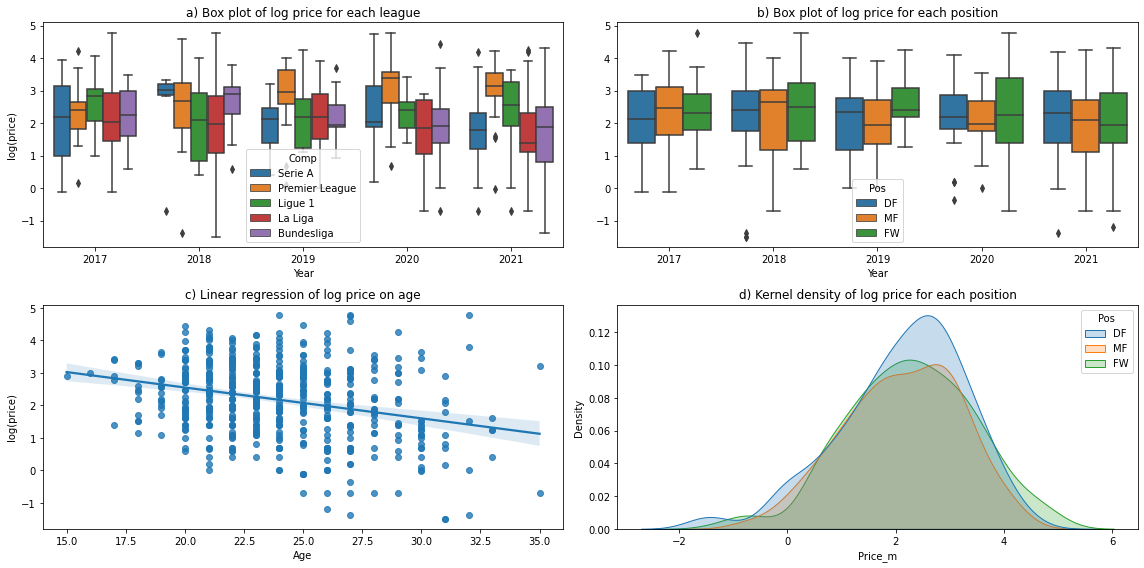

In [14]:
# Import graphical packages
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# sns.set_theme(style="white")

# Data cleaning for copy paste
new_df=pd.read_csv('Main_df.csv')
new_df['Price_m'] = np.log(new_df['Price_m'])
# new_df = new_df[new_df.Pos != 'GK']

# Define plot
f,ax = plt.subplots(2,2, figsize=(16,8))

# First row
sns.boxplot(x='Year', y='Price_m', data=new_df, hue="Comp", ax=ax[0, 0]).set( xlabel = "Year", ylabel = "log(price)")
ax[0,0].set_title('a) Box plot of log price for each league')
sns.boxplot(x='Year', y='Price_m', data=new_df, hue="Pos", ax=ax[0, 1]).set( xlabel = "Year", ylabel = "") # second box plot
ax[0,1].set_title('b) Box plot of log price for each position')
# Second row
sns.regplot(x='Age', y='Price_m', data=new_df, ax=ax[1, 0]).set( xlabel = "Age", ylabel = "log(price)") #Linear regression
ax[1,0].set_title('c) Linear regression of log price on age')
sns.kdeplot(x=new_df['Price_m'], data=new_df, hue="Pos",shade=True, ax=ax[1,1]) # Kernel plot
ax[1,1].set_title('d) Kernel density of log price for each position')
f.tight_layout()



# # Create path to save figure
# fp_figs = Path.cwd() / 'figs'  
# # Use the Path object to actually create the subfolder
# Path.mkdir(fp_figs, exist_ok=True)  
# # Export for paper
# plt.savefig('figs/pic2.png')




### **Selection of relevant independent variables for models**

In [15]:
# Import csv file as dataframe
modeldata=pd.read_csv('Main_df.csv')

# Define all variables needed in analysis
all_variables = ['Pos','Age','Ast','G-PK','CrdY','CrdR','Cmp%','1/3',
'Int','Tkl%', 'Price_m','Comp']

# Filter so only variables need in analysis included
modeldata = modeldata[all_variables]

# Delete GK
modeldata = modeldata[modeldata.Pos != 'GK']

# Convert position and competiion to dummies
positioncolumn = ['Pos','Comp']
modeldata= pd.get_dummies(modeldata, columns=positioncolumn,drop_first=True)
# Convert minutes to float
# modeldata['Min'] = modeldata['Min'].str.replace(',','')

# Fill nan with zeroes (nan only present when the playes has had in fact zero)
modeldata = modeldata.fillna(0)

# Convert to float
modeldata = modeldata.astype(float)

# # Define y and x
# y = modeldata['Price_m']
y = np.log(modeldata['Price_m'])
X = modeldata.loc[:, modeldata.columns != 'Price_m']
X = sm.add_constant(X)


### **OLS**

In [16]:
# Set up OLS
# olsmod = sm.OLS(y, X)
# olsres = olsmod.fit()
# print(olsres.summary())

# MSE
from random import random


def rmse(y_pred, y_true):
    return np.sqrt(mse(y_pred, y_true))

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)    
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=1)

# Set up regression
reg = LinearRegression(fit_intercept=False).fit(X_train, y_train)
pred = reg.predict(X_test)

# Calculate the root mean squared error and print the result
mse_val = rmse(reg.predict(X_dev), y_dev)

print(mse_val)

# Dataframe to contain regression models coefficients
coefficients = pd.DataFrame(reg.coef_, X.columns, columns=['OLS'])

                            OLS Regression Results                            
Dep. Variable:                Price_m   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     25.69
Date:                Sun, 21 Aug 2022   Prob (F-statistic):           1.60e-53
Time:                        22:14:07   Log-Likelihood:                -695.10
No. Observations:                 546   AIC:                             1422.
Df Residuals:                     530   BIC:                             1491.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.3453    

<AxesSubplot:>

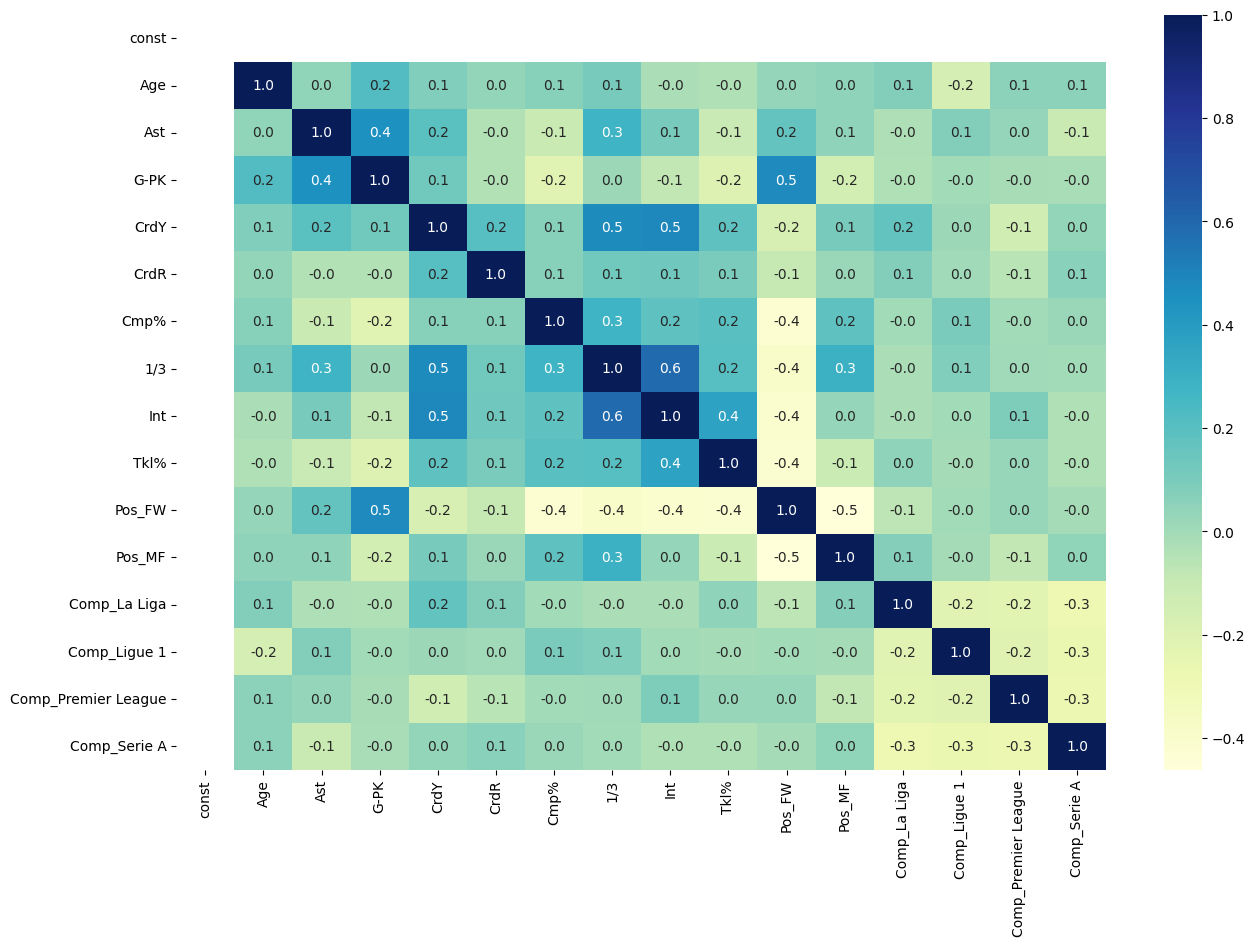

In [17]:
from matplotlib.pyplot import figure
corr_matrix = X.corr()
corr_matrix

figure(figsize=(15,10), dpi=100)
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu',fmt=".1f")

# fp_figs = Path.cwd() / 'figs'  
# # Use the Path object to actually create the subfolder
# Path.mkdir(fp_figs, exist_ok=True)  
# # Export for paper
# plt.savefig('figs/heatmap_v2.png')



# corr_matrix = X_1.corr()
# corr_matrix

# figure(figsize=(15,10), dpi=100)
# sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu',fmt=".1f")

# fp_figs = Path.cwd() / 'figs'  
# # Use the Path object to actually create the subfolder
# Path.mkdir(fp_figs, exist_ok=True)  
# # Export for paper
# plt.savefig('figs/heatmap_v1.png')

# PosValue = df.groupby(['Position'])['NetValue'].mean().reset_index()
# sns.barplot(x = 'Position',y='NetValue',data=PosValue)     
# plt.ylabel('Net Value - Million € ')

# df['AgeNorm']= (40-df['Age'])**2



### **Lasso Regression**


In [18]:
import sklearn
from sklearn.linear_model import LinearRegression

# **Lasso Regression**


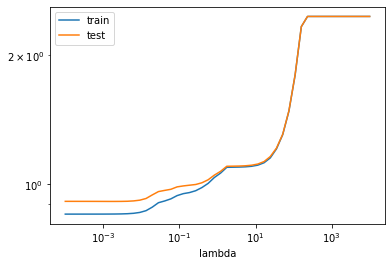

In [18]:
# We split the data set into training and test
# Make pipeline for Lasso

pipe_lasso = make_pipeline(Lasso(fit_intercept=False))

# Define range of lambdas
lambdas =  np.logspace(-4, 4, 50)

# Get train and test scores for different values of lambda

train_scores, test_scores = \
    validation_curve(estimator=pipe_lasso,
                     X=X_dev,
                     y=y_dev,
                     param_name='lasso__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',# scoring='neg_mean_squared_error',                 
                     cv=5)

# Get mean of mse for lambdas

lasso_rmse = pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
                         'test': pd.DataFrame(-test_scores).mean(1), 
                         'lambda': pd.DataFrame(lambdas).mean(1)}, axis =1)

# Plot the train and test scores for different values of lambda

pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
           'test': pd.DataFrame(-test_scores).mean(1)},
           axis=1)\
    .pipe(np.sqrt)\
    .set_index(pd.Index(lambdas, name='lambda'))\
    .plot(logx=True, logy=True)

plt.show()

In [19]:
# We use the function to fit it and find the best lambda and corresponding mse

from sklearn.model_selection import GridSearchCV

gs = GridSearchCV(estimator=pipe_lasso, 
                  param_grid=[{'lasso__alpha':lambdas}], 
                  scoring='neg_mean_squared_error', 
                  cv=5, 
                  n_jobs=-1)

gs = gs.fit(X_dev, y_dev)
print(gs.best_params_, gs.best_score_)

lasso_coefs = gs.best_estimator_.named_steps.lasso.coef_

{'lasso__alpha': 0.0013894954943731374} -0.8323856504650005


### **Ridge Regression**

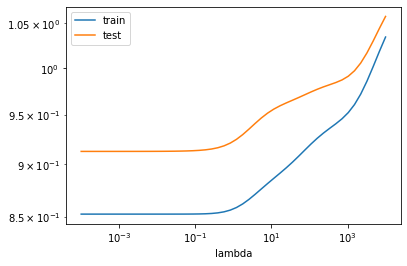

In [20]:
# Make pipeline for Ridge

pipe_ridge = make_pipeline(Ridge(fit_intercept=False))

# Get train and test scores for different lambdas

train_scores, test_scores = \
    validation_curve(estimator=pipe_ridge,
                     X=X_dev,
                     y=y_dev,
                     param_name='ridge__alpha',
                     param_range=lambdas,
                     scoring='neg_mean_squared_error',# scoring='neg_mean_squared_error',                 
                     cv=5)

# Get mean of mse for lambdas

ridge_rmse = pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
                         'test': pd.DataFrame(-test_scores).mean(1), 
                         'lambda': pd.DataFrame(lambdas).mean(1)}, axis =1)

# Get test rsme for plot later
#ridge_rmse = pd.concat({'test': pd.DataFrame(-test_scores).mean(1)}, axis = 1)

# Plot the train and test scores for different values of lambda

pd.concat({'train': pd.DataFrame(-train_scores).mean(1), 
           'test': pd.DataFrame(-test_scores).mean(1)},
           axis=1)\
    .pipe(np.sqrt)\
    .set_index(pd.Index(lambdas, name='lambda'))\
    .plot(logx=True, logy=True)
plt.show()

In [21]:
# Another method to identify best lambda to minimze mse

gs = GridSearchCV(estimator=pipe_ridge, 
                  param_grid=[{'ridge__alpha':lambdas}], 
                  scoring='neg_mean_squared_error', 
                  cv=5, 
                  n_jobs=-1)

# We use the function to fit it and find the best lambda and corresponding mse
gs = gs.fit(X_dev, y_dev)
print(gs.best_params_, gs.best_score_ )

coefficients['Ridge'] = gs.best_estimator_.named_steps.ridge.coef_

{'ridge__alpha': 0.0001} -0.8332192794246664


### **Plot of RSME for Lasso and Ridge**

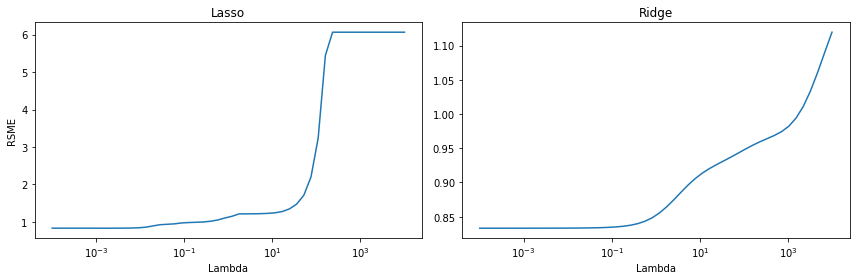

In [22]:
# Define plot
f,ax = plt.subplots(1,2, figsize=(12,4))

# First row
sns.lineplot(x='lambda', y='test', data=lasso_rmse, ax=ax[0]).set( xlabel = "Lambda", ylabel = "RSME", xscale='log', title='Lasso')
sns.lineplot(y='test', x='lambda', data=ridge_rmse, ax=ax[1]).set( xlabel = "Lambda", ylabel = "", xscale='log', title='Ridge')

f.tight_layout()

# Export for paper
plt.savefig('figs/pic2.png')

### **Include all variables in Ridge and Lasso for test**

In [23]:
test_stats = ['Pos','Age','MP','Starts','90s','Gls','Ast','G-PK','CrdY','CrdR','Cmp%','KP','1/3','PPA','CrsPA',
'Prog','Tkl','TklW','Int','Err','Blocks','Tkl%','Comp','Price_m']


modeldata=pd.read_csv('Main_df.csv')

modeldata = modeldata[test_stats]

# Delete GK
modeldata = modeldata[modeldata.Pos != 'GK']

# Convert position and competiion to dummies
positioncolumn = ['Pos','Comp']
modeldata= pd.get_dummies(modeldata, columns=positioncolumn,drop_first=True)
# Convert minutes to float
# modeldata['Min'] = modeldata['Min'].str.replace(',','')

# FIll nan with zeroes (nan only present when the playes has had in fact zero)
modeldata = modeldata.fillna(0)

# Convert to float
modeldata = modeldata.astype(float)

# # Define y and x
# y = modeldata['Price_m']
y = np.log(modeldata['Price_m'])
X = modeldata.loc[:, modeldata.columns != 'Price_m']
X = sm.add_constant(X)

X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/3, random_state=1)   

gs = GridSearchCV(estimator=pipe_lasso, 
                  param_grid=[{'lasso__alpha':lambdas}], 
                  scoring='neg_mean_squared_error', 
                  cv=5, 
                  n_jobs=-1)

gs = gs.fit(X_dev, y_dev)
print(gs.best_params_, gs.best_score_)

gs = GridSearchCV(estimator=pipe_ridge, 
                  param_grid=[{'ridge__alpha':lambdas}], 
                  scoring='neg_mean_squared_error', 
                  cv=5, 
                  n_jobs=-1)

# We use the function to fit it and find the best lambda and corresponding mse
gs = gs.fit(X_dev, y_dev)
print(gs.best_params_, gs.best_score_ )

# Only marginally better RSME, no need to include in project

{'lasso__alpha': 0.004291934260128779} -0.7940095781522606
{'ridge__alpha': 0.0001} -0.795705791395172
